# Proximal Policy Optimization from scratch

#### This notebook demonstrates the Proximal Policy Optimization algorithm described in the paper [Proximal Policy Optimization Algorithms](https://arxiv.org/pdf/1707.06347).

In [1]:
!python -m pip install tqdm torch tensorboard -e ./PyGame-Learning-Environment/PyGame-Learning-Environment-master -qqq

In [2]:
import os
import time
from datetime import timedelta
from tqdm import tqdm
import torch
from torch import Tensor
import numpy as np
import ple
import random
import tempfile
import typing
from pprint import pprint
from torch.utils.tensorboard import SummaryWriter
from IPython.display import clear_output
from abc import ABC, abstractmethod
clear_output()

## Define Models

In [3]:
class ValueModel(torch.nn.Module):
    """
    Estimates the expected reward from the given state.
    """

    def __init__(self, 
                 in_feature_len: int,               
                 hidden_neuron_len: int,
                 learning_rate: float,
                ):
        super().__init__() 
        self.linear1 = torch.nn.Linear(in_feature_len, hidden_neuron_len)
        self.linear2 = torch.nn.Linear(hidden_neuron_len, 1)
        self.optimizer = torch.optim.Adam(lr=learning_rate, params=self.parameters())
        self.loss = torch.nn.MSELoss()

    def forward(self, input: Tensor) -> Tensor:
        x = torch.nn.ReLU()(self.linear1(input))
        x = self.linear2(x)
        return x

class PolicyModel(torch.nn.Module):
    """
    Determines the best action to take given a state. 
    """

    def __init__(self,
                 in_feature_len: int, 
                 out_feature_len: int,                 
                 hidden_neuron_len: int, 
                 learning_rate:float,
                 model_path: str = None
                ):
        super().__init__()
        self.in_feature_len = in_feature_len
        self.hidden_neuron_len = hidden_neuron_len
        self.out_feature_len = out_feature_len
        self.learning_rate = learning_rate
        self.model_path = model_path        
        
        self.linear1 = torch.nn.Linear(in_feature_len, hidden_neuron_len)
        self.linear2 = torch.nn.Linear(hidden_neuron_len, out_feature_len)
        self.optimizer = torch.optim.Adam(lr=self.learning_rate, params=self.parameters())

    def forward(self, x: Tensor) -> Tensor:
        x = torch.nn.ReLU()(self.linear1(x))
        x = torch.nn.Softmax(dim=-1)(self.linear2(x))      
        return x

    def _copy(self, model_path) -> torch.nn.modules:
        """
        Makes a copy of this model by first saving it's weights to the local fileshare,
        creating a new instance of this class, and then loading the weights to the model.

        Args:
            model_path (str): The local path that the model's weights should be saved to.

        Returns:
            A new torch.nn.modules containing the same weights as were saved to the 
            local fileshare. 
        """
        torch.save(self.state_dict(), self.model_path)
        new_model = PolicyModel(
            in_feature_len=self.in_feature_len, 
            hidden_neuron_len=self.hidden_neuron_len, 
            out_feature_len = self.out_feature_len,
            learning_rate = self.learning_rate,
            model_path = self.model_path
        )
        new_model.load_state_dict(torch.load(model_path, weights_only=True))
        return new_model

    def copy(self) -> torch.nn.modules:
        """
        Creates a copy of the current model by using the copy helper method to first 
        save the model to the local file share. If this class instance does not have
        a model_path defined then it will use a temporary path to pass to the copy
        helper method. 

        Returns:
            A new torch.nn.modules instance containing the same weights saved to the 
            local fileshare. 
        """
        model = None
        if self.model_path is not None:
            model = self._copy(self.model_path)
        else:
            with tempfile.TemporaryDirectory() as dir_name:
                model_path = os.path.join(dir_name,'temp.model')
                model = self._copy(model_path)
        return model

## Define Generator

In [4]:
class Range:
    min: float | np.ndarray | None = None
    max: float | np.ndarray | None = None

class Generator:
    """
    Generator of training data for PPO Algorithm.
    https://arxiv.org/pdf/1707.06347

    Example:

        policy = PolicyModel(...)
    
        generator = Generator(
            ple = ple, 
            policy = old_policy, 
            action_list = ACTIONS, 
            environments_len = ENV_LEN, 
            episode_len = EPISODE_LEN, 
            mini_batch_size = MINI_BATCH_SIZE, 
            device = DEVICE,
            epoch_repeat = EPOCH_REPEAT,
        )
        
        for mini_batch in generator(policy):
            current_state, action_index, action_confidence, reward, next_state = mini_batch
            # Do something with each column vector
    
    """

    def __init__(
        self, 
        ple: ple.PLE, 
        policy: torch.nn.Module, 
        action_list: list[int | None], 
        environments_len: int, 
        episode_len: int,
        mini_batch_size: int, 
        device: str, 
        epoch_repeat: int = 0
    ):
        """

        Args:
            ple (ple.PLE): An instance of the Python Learning Environment. 
            policy (torch.nn.Module): A Torch Neural Nework Module that suggests the 
                action to take given a state.
            action_list (int | None): The list of values that the PLE will interpret as 
                valid actions in the Pygame environment.
            environments_len (int): The number of environments that the training data should 
                be gathered from. Ideally they would be executed parallelly, but this capability
                is  not currently offered by PLE. For now we'll execute them sequentially. 
            episode_len (int): The number of steps that should be taken within an environment 
                for gathering the training data.
            mini_batch_size (int):
                The number of data samples that should be fetched from the training data 
                during training.
            device (str):
                The device that Torch should use process the data on. Examples of valid options
                are 'cpu' and 'cuda'.
            epoch_repeat (int): The number of extra times to yield the same full set of data 
                from a single generation.             
        """

        self.ple = ple
        self.policy = policy
        self.action_list = action_list
        self.environments_len = environments_len
        self.episode_len = episode_len
        self.mini_batch_size = mini_batch_size
        self.device = device
        self.epoch_repeat = epoch_repeat
        
        self.norm: dict[str, Range] = {}
        self.action_indexes: list[int] = list(range(len(self.action_list)))
        self.data_len = self.environments_len * self.episode_len
        self.state_len = len(self.ple.getGameState())
        self.smallest_positive_num = 1/np.iinfo(np.int32).max 
        self.iter: int = 0
        self.scores: list[float] = []

    def _get_normalized(self, value: int | float | np.ndarray, key: str) -> int | float | np.ndarray:
        """
        For a given value of a specific producer, keeps track of the minimum and maximum values
        encountered by that producer, normalizes the given value inclusively between
        the range of 0 and 1, and returns the result. This is useful for when you don't know 
        the value limits of the features of the state, prior to running the algorithm. 
        Uses a locally defined Range class to enhance readability of the code.


        Args:
            value (int | float | np.ndarray): The value to be normalized.
            key (str): The unique identifier of the producer of the data provided.

        Returns:
            The normalized data between the range of 0 and 1. Valid return types are int, float, 
            and np.ndarray.
        
        """
        if key not in self.norm:
            self.norm[key] = Range()

        if self.norm[key].min is not None:
            self.norm[key].min = np.min([self.norm[key].min, value], axis=0)
        else:
            self.norm[key].min = value

        if self.norm[key].max is not None:
            self.norm[key].max = np.max([self.norm[key].max, value], axis=0)
        else:
            self.norm[key].max = value            
            
        diff = self.norm[key].max - self.norm[key].min

        # Attempting to avoid the division by zero error
        if type(value) is np.ndarray:
            diff[diff < self.smallest_positive_num] = self.smallest_positive_num        
        else:
            diff = self.smallest_positive_num if diff < self.smallest_positive_num else diff
            
        normalized_value = (value - self.norm[key].min)/diff  

        if type(value) is np.ndarray:
            assert normalized_value.all() >= 0
            assert normalized_value.all() <= 1            
        else:
            assert normalized_value >= 0
            assert normalized_value <= 1            
            
        assert not np.isnan(normalized_value).any()  
        return normalized_value

    def _validate_data(self, data: Tensor, shape: tuple, tensor_dtype: torch.dtype, 
                       requires_grad: bool, device: str) -> None:
        """
        Ensures that validation happens for each of these properties (no default values are provided).

        Args:
            data (Tensor): The data to be validated.
            shape (tuple): The expected shape of the data.
            tensor_dtype (torch.dtype): The expected data type of the data provided.
            requires_grad (bool): Whether or the the tensor provide should require the 
                gradient function for back propagation
            device (str): The expected device that the tensor should run on.
        """
        assert data.shape == shape
        assert data.dtype == tensor_dtype
        assert data.requires_grad == requires_grad
        assert str(data.device) == self.device

    def _generate_trajectories(self) -> "tuple[Tensor[float], Tensor[int], Tensor[float], Tensor[float], Tensor[float]]":
        """
        Generates trajectectories to train on. For each new environment, steps through 
        the environment one frame at a time up to the definied episode length. Upon 
        each new step records the current step, action taken, confidence level of the 
        action taken, reward, and the next step. During this process the data is converted 
        to Tensors, validated, and returned as column vectors in Tensor form.

        
        Returns:
            A tuple of column vector as tensors. Each of the tensors are an n x m matrix where n is the
            length of the product of the environment length and episode length.
            
            - First tensor is an n x m Matrix of current states, where m is the number of features in a state.
            - Second tensor is a n x 1 Matrix of action indexes.
            - Third tensor is a n x 1 Matrix of the confidence of the action taken by the policy.
            - Fourth tensor is a n x 1 Matrix of the reward received by taking the chosen action 
              from the current state.
            - Fifth tensor is a n x m Matrix of next states, where m is the numver of features in a state.
        """
        
        current_state_list = []
        action_index_list = []
        action_confidence_list = []
        reward_list = []
        next_state_list = []
        episode_len_and_padding = self.episode_len + 1
        self.scores = []


        # Each new environment begins with a game reset. Ideally everything
        # within this loop is parrallelized but PLE does not support this, so
        # we run it sequenctially.
        for env_i in tqdm(range(self.environments_len), mininterval = 1):
            self.scores.append(self.ple.score())            
            self.ple.reset_game()
            
            for frame_i in range(episode_len_and_padding): # Number of Frames (i.e. frames per second)
                if self.ple.game_over():
                    self.scores.append(self.ple.score())
                    self.ple.reset_game()
                    
                state = np.array(list(self.ple.getGameState().values()))
                state = self._get_normalized(value = state, key = 'state')
                
                one_hot_action = self.policy(torch.tensor(state)).detach()
                
                # The higher the confidence of any action, the lower the exploration of the remaining actions.
                chosen_action_index = random.choices(self.action_indexes, weights=one_hot_action, k=1)[0]
                
                chosen_action_confidence = one_hot_action[chosen_action_index]
                chosen_action = self.action_list[chosen_action_index]
                
                reward = self.ple.act(chosen_action)
                assert type(reward) == int or type(reward) == float or type(reward) or np.float64

                state = state.tolist()
                                          
                # Given that each list below is a column vector of a matrix of trajectory data, this 
                # is the equivalent of setting the "next state" in the same row of the "current state"
                if frame_i > 0:
                    next_state_list.append(state)      
                    
                # Adds all of the rows except for the last since there will not 
                # be a "next state" to include with it
                if (frame_i + 1) < episode_len_and_padding:
                    current_state_list.append(state)
                    action_index_list.append(chosen_action_index)
                    action_confidence_list.append(chosen_action_confidence)
                    reward_list.append(reward)

        # Converts columns to Tensors and validate
        current_state = torch.tensor(current_state_list)
        self._validate_data(
            data = current_state, 
            shape = (self.data_len, self.state_len), 
            tensor_dtype = torch.get_default_dtype(), 
            requires_grad = False, 
            device = self.device
        )

        action_index = torch.tensor(np.array(action_index_list)).reshape(-1, 1)
        self._validate_data(
            data = action_index, 
            shape = (self.data_len, 1), 
            tensor_dtype = torch.int64, 
            requires_grad = False, 
            device = self.device
        )       
        
        action_confidence = torch.vstack(action_confidence_list).reshape(-1, 1)
        self._validate_data(
            data = action_confidence, 
            shape = (self.data_len, 1), 
            tensor_dtype = torch.get_default_dtype(), 
            requires_grad = False, 
            device = self.device
        )     

        reward = torch.tensor(reward_list).reshape(-1,1)
        self._validate_data(
            data = reward, 
            shape = (self.data_len, 1), 
            tensor_dtype = torch.get_default_dtype(), 
            requires_grad = False, 
            device = self.device
        )   
               
        next_state = torch.tensor(next_state_list)
        self._validate_data(
            data = next_state, 
            shape = (self.data_len, self.state_len), 
            tensor_dtype = torch.get_default_dtype(), 
            requires_grad = False, 
            device = self.device
        )

        column_vectors = (current_state, action_index, action_confidence, reward, next_state)
        return column_vectors

    def __call__(self, policy: Tensor) -> tuple[Tensor, Tensor, Tensor, Tensor, Tensor]:
        """ 
        Yields a minibatch of column vectors in the form of tensors, based on the paramters 
        provided to the constructor of this class. First gets the column vectors, constructs 
        a shuffled array of indexes having the same length as the row length of the column 
        vectors, and then yields them in batches by the shuffled indexes, reshuffling the 
        indexes at each repeated epoch. The benefit of repeating epochs, on each set of 
        generated data, is better model accuracy over the same time period. This is achieved by
        reducing the total number of data generation sequences, as they have a significantly higher 
        time complexity than the training sequences. This comes at the risk of overfitting the 
        policy model to any given set of generated data, due to progressively updated models 
        being fitted to data generated from older, less accurate, versions of the policy model.

        Args:
            policy (Tensor): the updated version of the policy to use for generating the data.
        
        Yields:
            A minibatch of column vectors in the form of tensors, based on the parameters provided
            to the constructor of this class.
        """
        self.policy = policy
        with torch.device(self.device), torch.no_grad():

            trajectories =  self._generate_trajectories()
            for epoch_i in range(1 + self.epoch_repeat):
                
                shuffled_indices = torch.randperm(self.data_len)
                shuffled_column_vectors =  tuple(col_vector[shuffled_indices] for col_vector in trajectories)
                current_state, action_index, action_confidence, reward, next_state = shuffled_column_vectors   
                current_state, action_index, action_confidence, reward, next_state = trajectories
                
                for i in range(0, self.data_len, self.mini_batch_size):
                    select = slice(i, i + self.mini_batch_size)
                    yield tuple([
                        current_state[select], 
                        action_index[select], 
                        action_confidence[select],  
                        reward[select], 
                        next_state[select]
                    ])


## Environment Configs

In [5]:
from abc import ABC, abstractmethod

class ConfigBase(ABC):
    @property
    @abstractmethod
    def DISCOUNT(self) -> float:
        """
        The value for which to decay latter terms in a Trajectory.
        """
        pass

    @property
    @abstractmethod
    def EPSILON(self) -> float:
        """
        The value to use for clipping. 
        """
        pass
    
    @property
    @abstractmethod      
    def POLICY_HIDDEN_LEN(self) -> int:
        """
        The length of the hidden layer in the Policy Model.
        """
        pass

    @property
    @abstractmethod      
    def VALUE_HIDDEN_LEN(self) -> int:
        """
        The length of the hidden layer in the Value Model.
        """
        pass       

    @property
    @abstractmethod      
    def POLICY_LR(self) -> float:
        """
        The Learning Rate of the Policy Model. 
        """
        pass

    @property
    @abstractmethod      
    def VALUE_LR(self) -> float:
        """
        The Learning Rate of the Value Model.
        """
        pass

    @property
    @abstractmethod    
    def MODEL_PATH(self) -> str:
        """
        The local fileshare path for which the model should be saved to.
        """
        pass
        
    @property
    @abstractmethod    
    def ENV_LEN(self) -> int:
        """
        The number of the environments that should be created for generating
        training data in.
        """
        pass

    @property
    @abstractmethod    
    def EPISODE_LEN(self) -> int:
        """
        The number of frames that should make up an episode. Frame here is referring to the
        the image that is displayed as one of many images which makes up a motion picture. 
        """
        pass

    @property
    @abstractmethod    
    def MINI_BATCH_SIZE(self) -> int:
        """
        The number of data samples that should make up the subset of data for which 
        backpropagation should be applied to during training.
        """
        pass

    @property
    @abstractmethod    
    def EPOCHS(self) -> int:
        """
        The number of times to generate a full set of data and train on it at least once.
        """
        pass
    
    @property
    @abstractmethod    
    def EPOCH_REPEAT(self) -> int:
        """
        The number of times to repeat training on an already generated, and trained on, 
        epoch of data.
        """
        pass

    @property
    @abstractmethod    
    def DEVICE(self) -> str:
        """
        The device for which Torch will send the data to for processing. Some valid options
        include 'cpu', 'cuda', 'cuda:0', etc.
        """
        pass

    @property
    @abstractmethod
    def DEFAULT_DTYPE(self) -> torch.dtype:
        """
        The default data type to assume when creating a Tensor.
        Torch defaults to torch.float32.
        """
        pass

    @abstractmethod        
    def get_game_instance(self) -> ple.games.base.PyGameWrapper:
        """
        Returns a ple.games.base.PyGameWrapper instance. Settings specific
        to the desired PLE game should be applied here before returning the
        PyGameWrapper instance.
        """
        pass

    @property
    def ACTIONS(self):
        """
        Fetches the valid actions of the game.
        """
        if not hasattr(self, '_actions'):
            self._actions = [None] + list(self.get_game_instance().actions.values())
        return self._actions

    @property
    def as_dict(self):
        """
        Returns all properties of the implementing class as a dictionary. 
        """
        return {k: str(v.fget(self)) for k, v 
                in self.__class__.__dict__.items() if isinstance(v, property)}        

class Catcher(ConfigBase):
    @property
    def DISCOUNT(self) -> float:
        return 0.98

    @property
    def EPSILON(self) -> float:
        return 0.3
    
    @property
    def POLICY_HIDDEN_LEN(self):
        return 1000

    @property
    def VALUE_HIDDEN_LEN(self):
        return 1000        

    @property
    def POLICY_LR(self):
        return 1e-5

    @property
    def VALUE_LR(self):
        return 1e-3   

    @property
    def MODEL_PATH(self):
        return f"{self.__class__.__name__.lower()}.model"
        
    @property
    def ENV_LEN(self):
        return 200

    @property
    def EPISODE_LEN(self):
        return 92 * 5

    @property
    def MINI_BATCH_SIZE(self):
        return 1500

    @property   
    def EPOCHS(self):
        return 100   
    
    @property   
    def EPOCH_REPEAT(self):
        return 0       

    @property
    def DEVICE(self):
        return 'cuda:0'   

    @property
    def DEFAULT_DTYPE(self):
        return torch.float64
        
    def get_game_instance(self) -> ple.games.base.PyGameWrapper:
        if not hasattr(self, '_game'):
            self._game = ple.games.catcher.Catcher(width=64*8, height=64*8, init_lives=20)
        return self._game

class FlappyBird(ConfigBase):
    @property
    def DISCOUNT(self) -> float:
        return 0.97

    @property
    def EPSILON(self) -> float:
        return 0.3

    @property
    def POLICY_HIDDEN_LEN(self):
        return 1000
    
    @property
    def VALUE_HIDDEN_LEN(self):
        return 1000   

    @property
    def POLICY_LR(self):
        return 1e-5

    @property
    def VALUE_LR(self):
        return 1e-3 

    @property
    def MODEL_PATH(self):
        return f"{self.__class__.__name__.lower()}.model"
        
    @property
    def ENV_LEN(self):
        return 4000

    @property
    def EPISODE_LEN(self):
        return 90

    @property
    def MINI_BATCH_SIZE(self):
        return 1500

    @property   
    def EPOCHS(self):
        return 100           

    @property   
    def EPOCH_REPEAT(self):
        return 3           

    @property
    def DEVICE(self):
        return 'cuda:0'

    @property
    def DEFAULT_DTYPE(self):
        return torch.float64    
        
    def get_game_instance(self) -> ple.games.base.PyGameWrapper:
        if not hasattr(self, '_game'):
            self._game = ple.games.flappybird.FlappyBird()
        return self._game

## Load Tensorboard

In [6]:
%load_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 61904), started 0:32:36 ago. (Use '!kill 61904' to kill it.)

## The algorithm and formulas below have been taken directly from the [Proximal Policy Optimization Algorithms](https://arxiv.org/pdf/1707.06347) paper.

<hr/>

### The PPO algorithm is described by:
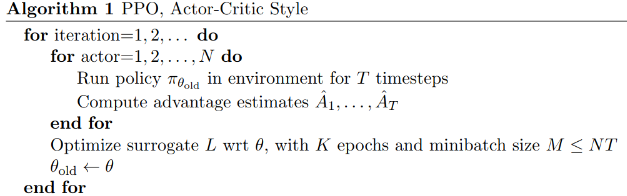

<hr/>

### The _loss_ function is described by:
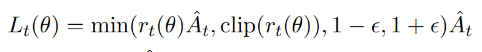

<hr/>

### $r_{t}$ is described by:
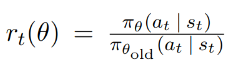

<hr/>

### $\hat{A}_{t}$ is described by:
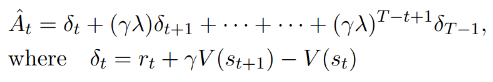

#### Supplemental reference for  $\updelta_{t}$ : [https://en.wikipedia.org/wiki/Temporal_difference_learning](https://en.wikipedia.org/wiki/Temporal_difference_learning).
#### $r_{t}$ in $\updelta_{t}$ is referring to **reward** and not the **r** formula above.
#### In the code below we simplify $\hat{A}_{t}$ above to become $\hat{A}_{t} = \updelta_{t}$ by setting _t_ to the range [T] where T = 0.
#### Therefore $\hat{A}_{t}$ above keeps the first term and truncates the rest.

<hr/>

### The _clip_ function is described by:
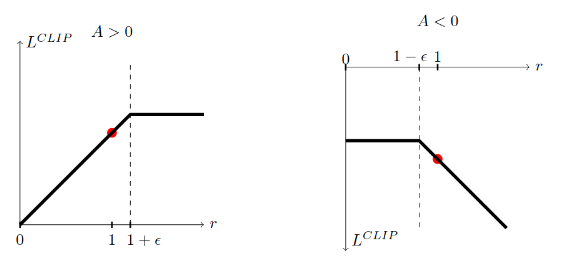

## Execute Training Loop

In [7]:
config = Catcher()
#config = FlappyBird()

# Save config to local fileshare  
torch.save(config.as_dict, f"{config.MODEL_PATH}.config")

tb_logger = SummaryWriter()
tb_logger.add_hparams(config.as_dict, {})

with torch.device(config.DEVICE):

    # We're changing the default precision to float64 to get the quickest convergence. 
    torch.set_default_dtype(config.DEFAULT_DTYPE)
    
    game = config.get_game_instance()
    ple = ple.PLE(game, fps=30, display_screen=False, force_fps=True)
    ple.init()

    action_len = len(config.ACTIONS)
    state_len = len(ple.getGameState())
    
    new_policy = PolicyModel(
        in_feature_len = state_len, out_feature_len = action_len , 
        hidden_neuron_len = config.POLICY_HIDDEN_LEN, learning_rate = config.POLICY_LR, 
        model_path = config.MODEL_PATH)
    new_policy.double()
    old_policy = new_policy.copy()
    old_policy.double()
    
    value_model = ValueModel(
        in_feature_len = state_len, 
        hidden_neuron_len = config.VALUE_HIDDEN_LEN, 
        learning_rate = config.VALUE_LR)
    value_model.double()

    tb_logger.add_text('Policy Model', str(new_policy))
    tb_logger.add_text('Policy Optimizer', str(new_policy.optimizer))
    tb_logger.add_text('Value Model', str(value_model), global_step=1)       
    tb_logger.add_text('Value Optimizer', str(value_model.optimizer))
    tb_logger.add_text('Config', str(config.as_dict)) 

    generator = Generator(
        ple = ple, 
        policy = old_policy, 
        action_list = config.ACTIONS, 
        environments_len = config.ENV_LEN, 
        episode_len = config.EPISODE_LEN, 
        mini_batch_size = config.MINI_BATCH_SIZE, 
        device = config.DEVICE,
        epoch_repeat=config.EPOCH_REPEAT
    )

    mini_batch_i = 0
    start_time = time.perf_counter()    
    for epoch_i in range(1, config.EPOCHS + 1):
        clear_output(wait = True)        
        print(f"Epoch: {epoch_i} of {config.EPOCHS}")
        pprint(config.as_dict, indent = 4)
        if epoch_i > 1:
            print(f"Max Score (over episodes in epoch): {np.max(generator.scores)}")
            print(f"Mean Score (over episodes in epoch): {np.mean(generator.scores)}")           
            tb_logger.add_scalar('\nMax Score (of mini-batch)', np.max(generator.scores), mini_batch_i - 1)  
            tb_logger.add_scalar('Mean Score (of mini-batch)', np.mean(generator.scores), mini_batch_i - 1)
            print(f"Elapsed Time:", timedelta(seconds = time.perf_counter() - start_time))
        
        for mini_batch in generator(policy = old_policy):
            with torch.enable_grad():
                current_state, action_index, action_confidence, reward, next_state = mini_batch

                assert current_state.requires_grad == False
                assert current_state.dtype == config.DEFAULT_DTYPE

                assert action_index.requires_grad == False
                assert action_index.dtype == torch.int64
                
                assert action_confidence.requires_grad == False
                assert action_confidence.dtype == config.DEFAULT_DTYPE

                assert reward.requires_grad == False
                assert reward.dtype == config.DEFAULT_DTYPE

                assert next_state.requires_grad == False
                assert next_state.dtype == config.DEFAULT_DTYPE                            

                current_value = value_model(current_state).detach()
                assert current_value.requires_grad == False
                assert current_value.dtype == config.DEFAULT_DTYPE

                next_value = value_model(next_state).detach()
                assert next_value.requires_grad == False
                assert next_value.dtype == config.DEFAULT_DTYPE

                #########################################################################
                #####################  SEE THE FORMULAS ABOVE  ########################## 
                expected_value = reward + (config.DISCOUNT * next_value)
                delta = expected_value - current_value
                a = delta
        
                new_action_confidence_distribution = new_policy(current_state).requires_grad_(True)
                select_all_rows = np.arange(new_action_confidence_distribution.shape[0]).reshape(-1,1)
                new_action_confidence = new_action_confidence_distribution[select_all_rows, action_index]         
               
                r = new_action_confidence / action_confidence
        
                loss_unclipped = r * a
                loss_clipped = torch.clip(r, 1 - config.EPSILON, 1 + config.EPSILON) * a

                # The -1 ensures gradient ascent is occuring instead of gradient descent
                p_loss = torch.minimum(loss_unclipped, loss_clipped) * -1
                
                p_loss_mean = p_loss.mean()
                
                old_policy = new_policy.copy()   
                new_policy.optimizer.zero_grad()
                p_loss_mean.backward()    
                new_policy.optimizer.step()
                #########################################################################
        
                if (
                    any([torch.isnan(param_tensor).any() for param_tensor in new_policy.parameters()]) 
                    and not any([torch.isnan(param_tensor).any() for param_tensor in old_policy.parameters()])
                ):
                    raise Exception("""NaN found in New Policy parameters. The magnitude of the Loss is \
                    too high. Try decreasing learning rate or adjusting the data.""")

                #########################################################################
                #######################  TRAIN THE VALUE MODEL  #########################
                current_value = value_model(current_state)
                assert current_value.requires_grad == True
                assert current_value.dtype == config.DEFAULT_DTYPE
                assert current_value.shape[1] == 1
                
                assert expected_value.requires_grad == False
                assert expected_value.dtype == config.DEFAULT_DTYPE
                
                v_loss = value_model.loss(current_value , expected_value)
                value_model.optimizer.zero_grad()        
                v_loss.backward()
                value_model.optimizer.step()
                #########################################################################

                if any([torch.isnan(param_tensor).any() for param_tensor in value_model.parameters()]):
                    raise Exception("""NaN found in Value Model parameters. The magnitude of the Loss is \
                    too high. Try decreasing learning rate or adjusting the data.""")          
                
                tb_logger.add_scalar('Policy Loss', p_loss_mean, mini_batch_i)
                tb_logger.add_scalar('Value Loss', v_loss, mini_batch_i)
                tb_logger.add_scalar('Reward', reward.mean(), mini_batch_i) 
                tb_logger.add_scalar('a', a.mean(), mini_batch_i)
                tb_logger.add_scalar('r', r.mean(), mini_batch_i)
                tb_logger.add_scalar('action_confidence', action_confidence.mean(), mini_batch_i)                
                tb_logger.add_scalar('new_action_confidence', new_action_confidence.mean(), mini_batch_i)

                mini_batch_i += 1

        # Save Min and Max values to local fileshare    
        torch.save(generator.norm['state'].__dict__, f"{config.MODEL_PATH}.min-max")        
print(f"Total Elapsed Time:", timedelta(seconds = time.perf_counter() - start_time))

Epoch: 100 of 100
{   'DEFAULT_DTYPE': 'torch.float64',
    'DEVICE': 'cuda:0',
    'DISCOUNT': '0.98',
    'ENV_LEN': '200',
    'EPISODE_LEN': '460',
    'EPOCHS': '100',
    'EPOCH_REPEAT': '0',
    'EPSILON': '0.3',
    'MINI_BATCH_SIZE': '1500',
    'MODEL_PATH': 'catcher.model',
    'POLICY_HIDDEN_LEN': '1000',
    'POLICY_LR': '1e-05',
    'VALUE_HIDDEN_LEN': '1000',
    'VALUE_LR': '0.001'}
Max Score (over episodes in epoch): 12.0
Mean Score (over episodes in epoch): 8.09
Elapsed Time: 0:45:44.671808


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:25<00:00,  7.73it/s]


Total Elapsed Time: 0:46:11.299483
